# Vietnam THOR dataset plots

## Links

* https://programminghistorian.org/en/lessons/visualizing-with-bokeh

In [2]:
import os, io, random
import string
import pickle
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from collections import OrderedDict
import datetime as dt
import geopandas as gpd

In [3]:
borders= gpd.read_file('SE_ASIA_PROVINCES_SV_NV_KH_LA.shp')
laosmap=borders[borders.COUNTRY=='LA']

In [ ]:
borders.plot(column='COUNTRY',cmap='Set3',lw=.5,ec='black',figsize=(10,10))
plt.savefig('seasia_map.jpg',dpi=150)

In [5]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):
    """convert mat long to web mercartor"""

    k = 6378137
    df.loc[:,"x"] = df[lon] * (k * np.pi/180.0)
    df.loc[:,"y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

## save small version of dataset with subsset of columns

In [ ]:
#df = pd.read_csv('thor_data_vietnam.csv')

In [8]:
cols = ['MSNDATE','TGTCOUNTRY','TAKEOFFLOCATION','WEAPONTYPE','MFUNC_DESC','TGTLATDD_DDD_WGS84','TGTLONDDD_DDD_WGS84']
#s=df[cols]
#s=s.sort_values('MSNDATE')
#s.to_csv('thor_data_vietnam_small.csv')

## pre process dataframe

In [9]:
s = pd.read_csv('thor_data_vietnam_small.csv', low_memory=False,index_col=0)
s['MSNDATE'] = pd.to_datetime(s.MSNDATE, format='%Y-%m-%d',errors='coerce')
s['YEAR'] = s.MSNDATE.dt.year.fillna(0).astype(int)
s['MONTH'] = s.MSNDATE.dt.month.fillna(0).astype(int)
s['MONTHNAME'] = s.MSNDATE.dt.month_name()
s=s[s.YEAR>0]
s = wgs84_to_web_mercator(s, lon="TGTLONDDD_DDD_WGS84", lat="TGTLATDD_DDD_WGS84")

/home/damien/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#temp save as pickle - so we can use in other notebooks
s.to_pickle('thor_small.pkl')
s = pd.read_pickle('thor_small.pkl')

In [11]:
#filter
x = s[~s.TGTLATDD_DDD_WGS84.isnull()].copy()
countries = ['NORTH VIETNAM','SOUTH VIETNAM','LAOS','THAILAND','CAMBODIA']
x = x[x.TGTCOUNTRY.isin(countries)]

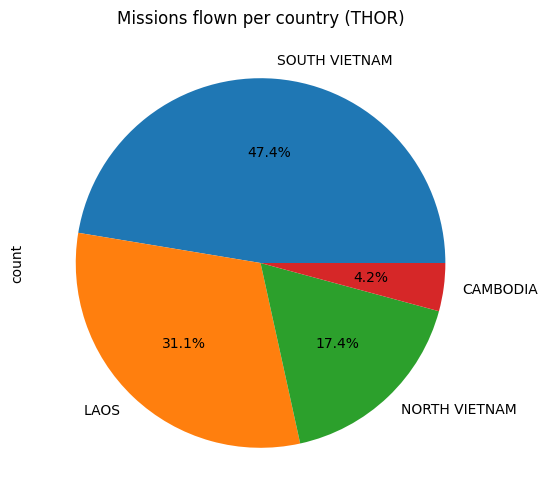

In [12]:
c = x.TGTCOUNTRY.value_counts()
c[:-1].plot(kind='pie',autopct='%1.1f%%',figsize=(6,6))
plt.title('Missions flown per country (THOR)')
plt.savefig('thor_seasia_summary_totals.jpg',dpi=100)

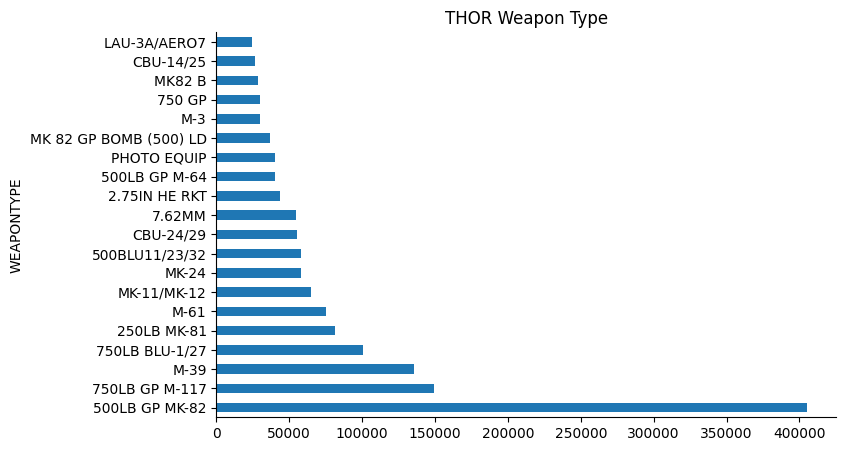

In [13]:
w = x.WEAPONTYPE.value_counts()
w[:20].plot(kind='barh',figsize=(8,5))
plt.title('THOR Weapon Type')
sns.despine()
plt.savefig('thor_seasia_weapontype.jpg',dpi=100)

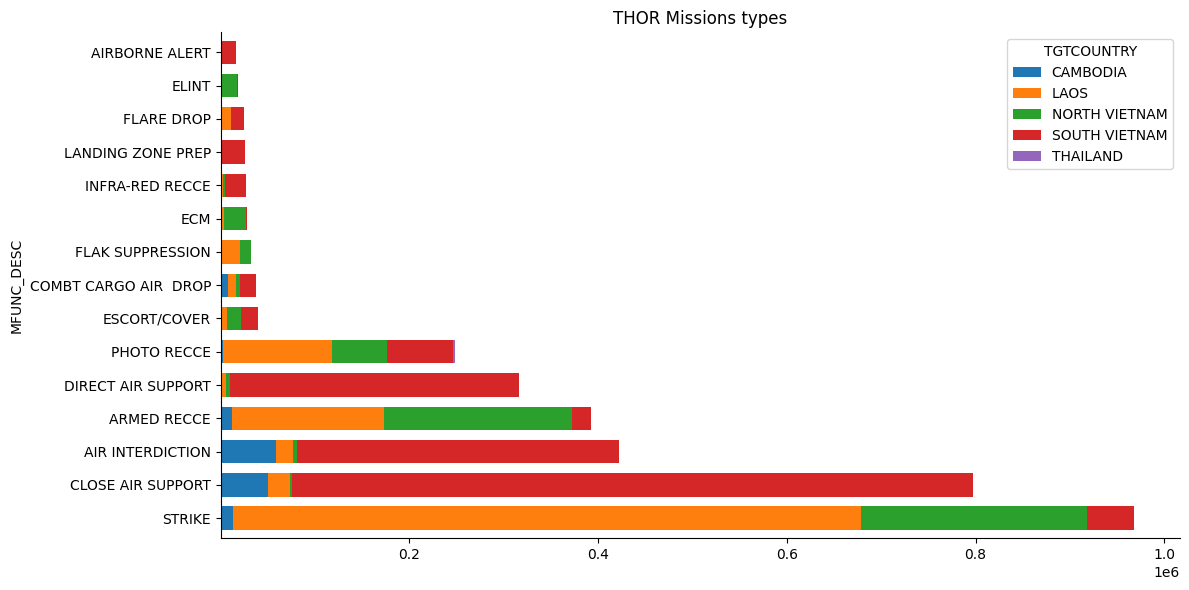

In [14]:
ms=x.MFUNC_DESC.value_counts()
mm = pd.pivot_table(x,index='MFUNC_DESC',columns=['TGTCOUNTRY'],values='x',aggfunc='size')
mm=mm.loc[ms.index[:15]]
mm.plot(kind='barh',stacked=True,width=.7,figsize=(12,6))
plt.title('THOR Missions types')
plt.tight_layout()
sns.despine()
plt.savefig('thor_seasia_mission_types.jpg',dpi=120)

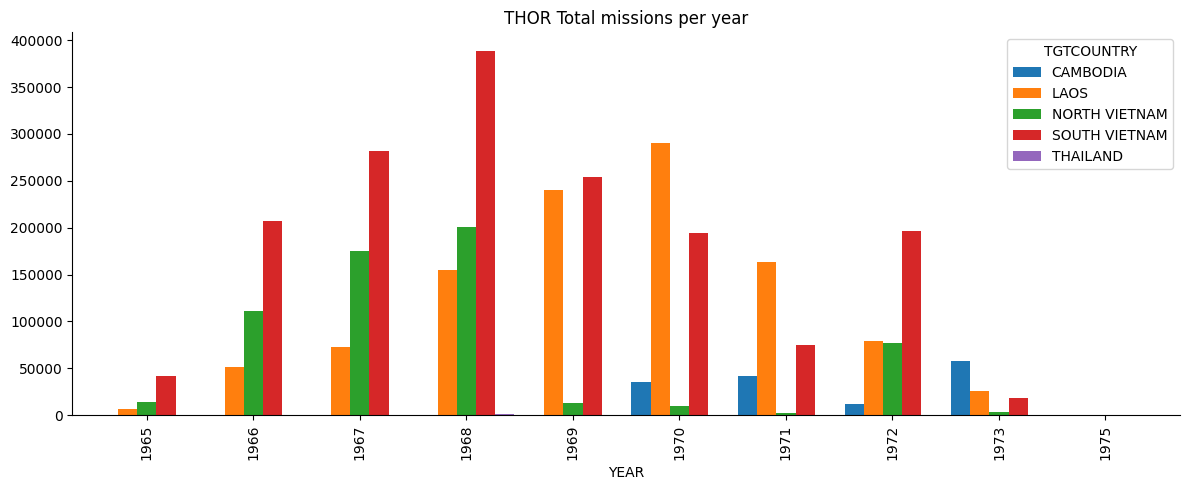

In [15]:
y=pd.pivot_table(x,index='YEAR',columns=['TGTCOUNTRY'],values='x',aggfunc='size')
y.plot(kind='bar',width=.9,figsize=(12,5))
plt.title('THOR Total missions per year')
plt.tight_layout()
sns.despine()
plt.savefig('thor_seasia_summary_byyear.jpg',dpi=120)

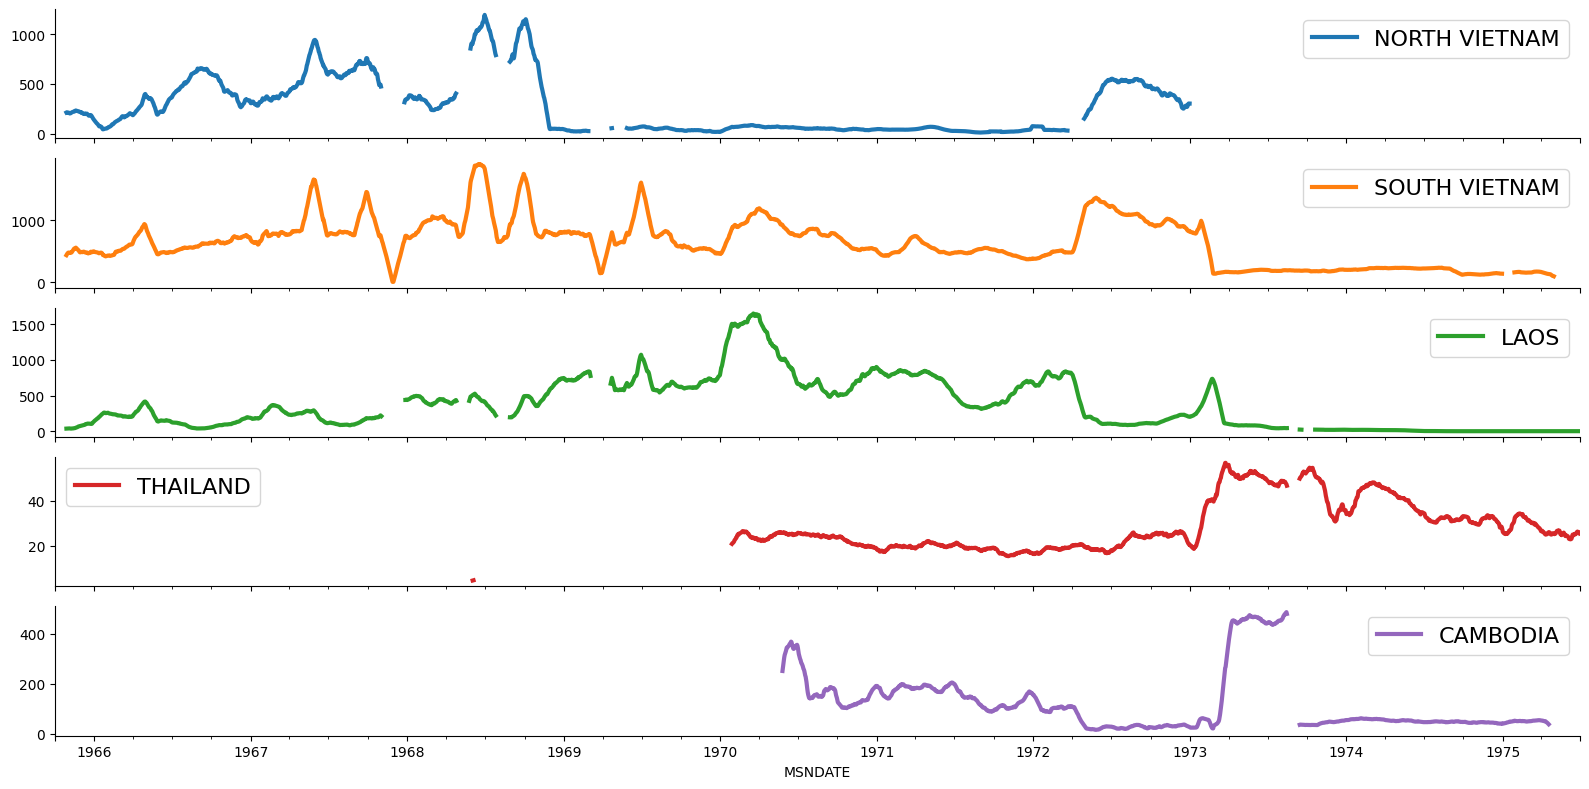

In [16]:
ts=pd.pivot_table(s,index='MSNDATE',columns=['TGTCOUNTRY'],values='x',aggfunc='size')[countries]
ts=ts.rolling(window=28).mean()
plt.rc('legend',fontsize=16) 
ax=ts.plot(lw=3,subplots=True,figsize=(16,8))
sns.despine()
plt.tight_layout()
plt.savefig('thor_seasia_time_series.jpg',dpi=120)

## laos

In [40]:
laos=x[x.TGTCOUNTRY=='LAOS']
gdf=gpd.GeoDataFrame(laos, geometry=gpd.points_from_xy(laos.TGTLONDDD_DDD_WGS84, laos.TGTLATDD_DDD_WGS84),crs="EPSG:4326")
laos=laos.sort_values(['YEAR','MONTH'])

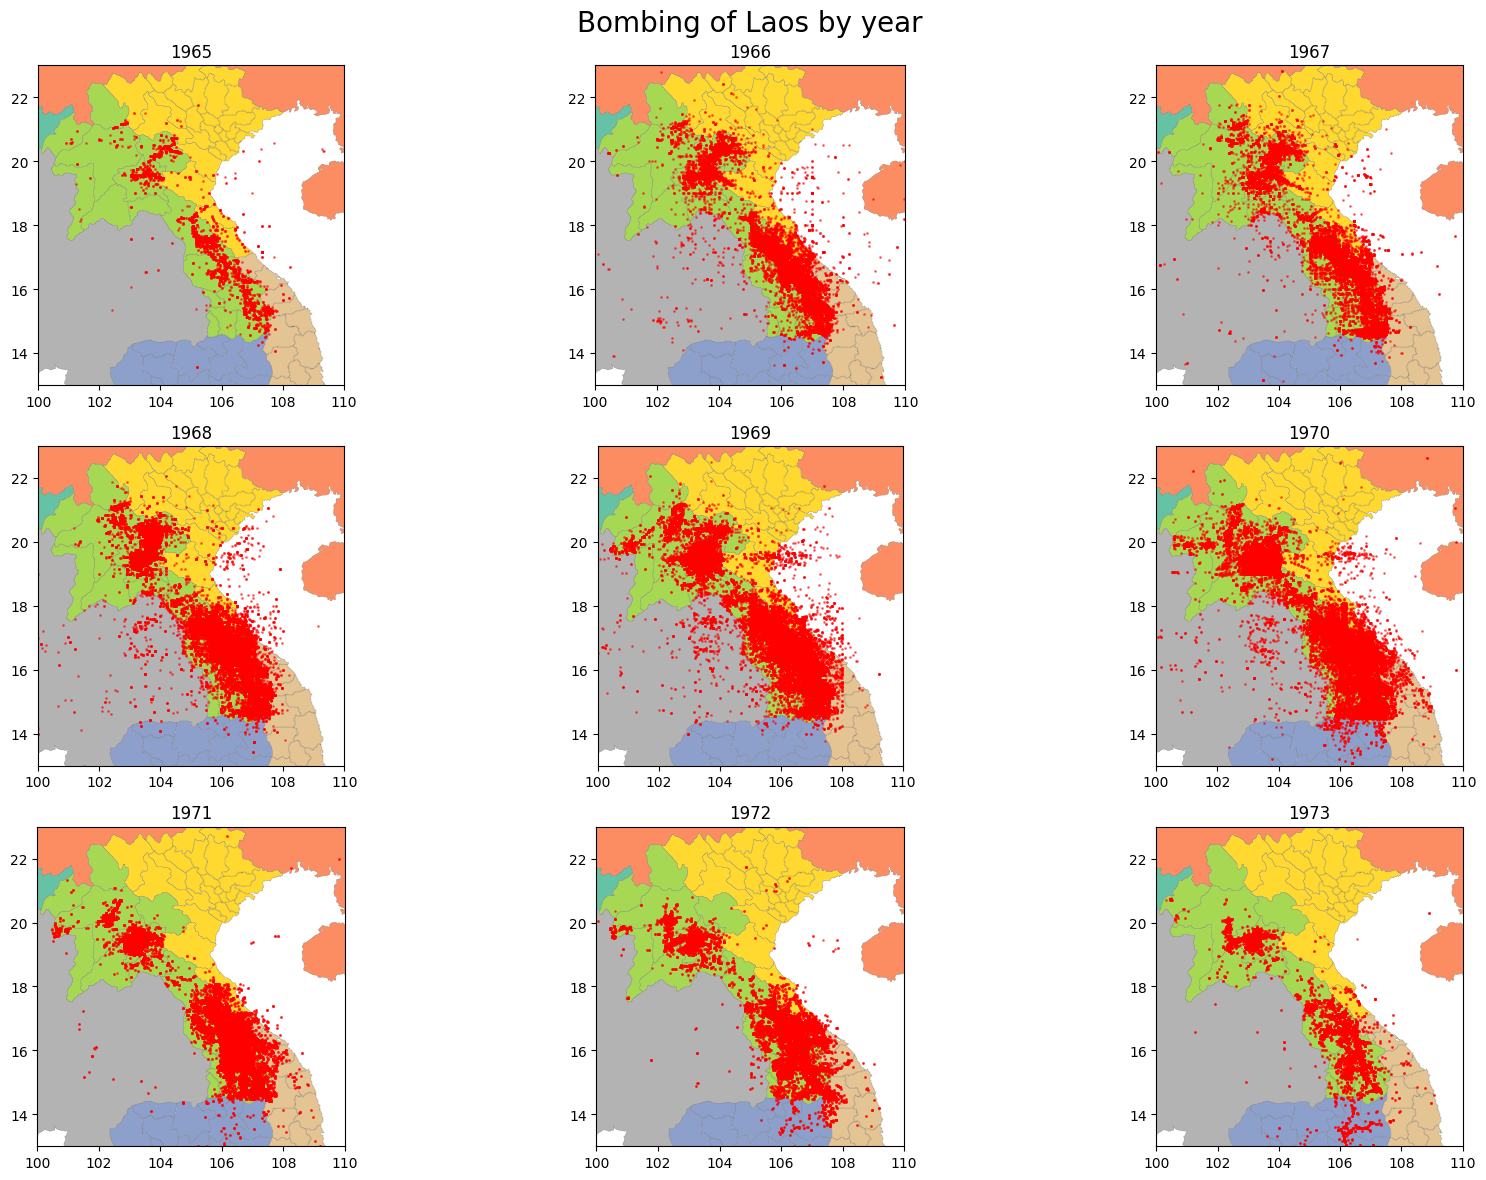

In [45]:
f,ax=plt.subplots(3,3,figsize=(18,12))
axs=list(ax.flat)
i=0
for y,g in gdf.groupby('YEAR'):
    ax=axs[i]
    borders.plot(column='COUNTRY',cmap='Set2',lw=.2,ec='gray',ax=ax)
    g.plot(color='red',markersize=1,alpha=.5,ax=ax)
    ax.set_xlim(100,110)
    ax.set_ylim(13,23)
    ax.set_title(y)    
    i+=1
f.suptitle('Bombing of Laos by year',fontsize=20)
plt.tight_layout()
plt.savefig('thor_laos_map_byyear.jpg',dpi=150)

## cluster bombs in laos

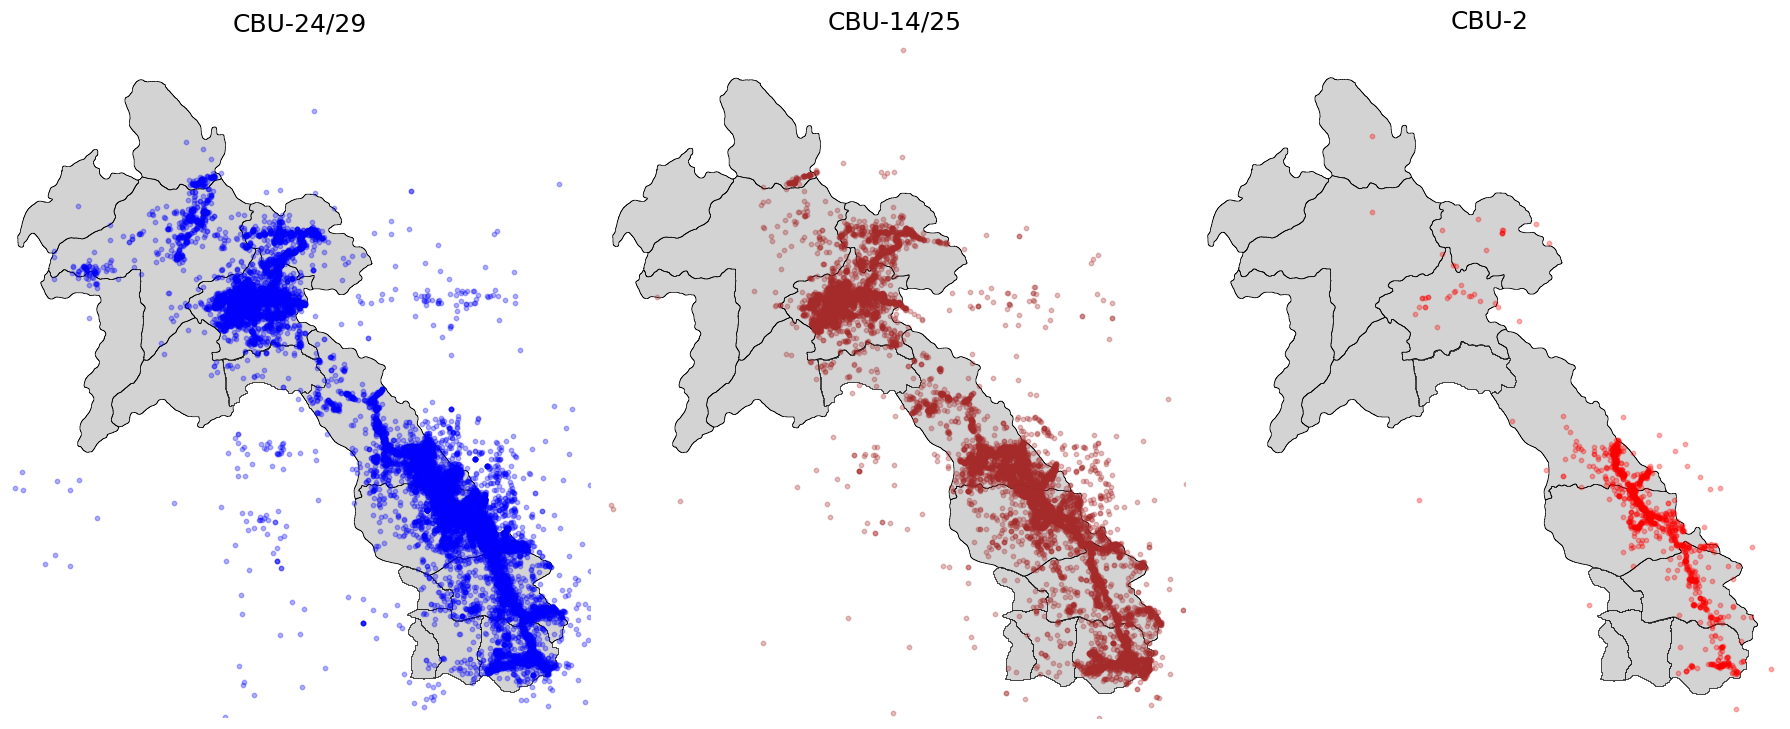

In [42]:
cluster_types=['CBU-24/29','CBU-14/25','CBU-2']
f,ax=plt.subplots(1,3,figsize=(18,12))
clrs=['blue','brown','red']
axs=list(ax.flat)
i=0
for c in cluster_types:
    ax=axs[i]
    cl = gdf[gdf.WEAPONTYPE==c]    
    laosmap.plot(color='lightgray',lw=.5,ec='black',ax=ax)
    cl.plot(color=clrs[i],markersize=10,alpha=.3,ax=ax)
    ax.set_xlim(100,108);ax.set_ylim(14,23)
    ax.set_title(c,fontsize=18)
    ax.axis('off')
    i+=1
plt.tight_layout()
f.savefig('thor_laos_cluster_bombs.jpg',dpi=150)

## geoplot kdeplot

In [ ]:
import geoplot as gplt
cl = gdf[gdf.WEAPONTYPE=='CBU-24/29']
ax=gplt.kdeplot(
    gdf[:2000], clip=laosmap.geometry,
    shade=True, cmap='Reds', shade_lowest=True,
    projection=gplt.crs.AlbersEqualArea(),figsize=(8, 8))
gplt.polyplot(laosmap, ax=ax, zorder=1)

In [ ]:
import geoplot.crs as gcrs
gplt.quadtree(gdf[:10], nmax=1)
gdf[:10]

## animate the plot

In [504]:
f = plt.figure(figsize=(9,8))
f.suptitle('LAOS BOMBING (THOR data)', fontsize=20)
mpl_pane.object = f
import time
time.sleep(5)
for date,g in gdf.groupby(['YEAR','MONTH'],sort=True):
    plt.clf()
    f.suptitle('LAOS BOMBING (THOR data)', fontsize=20)
    ax=f.add_subplot(label=date)
    laosmap.plot(column='COUNTRY',cmap='Set2',lw=1,ec='black',ax=ax)
    g.plot(color='red',markersize=10,alpha=.4,ax=ax)
    ax.set_xlim(100,108);ax.set_ylim(14,23)
    #ax.set_title(date.strftime("%b %d %Y"), fontsize=20)
    ax.set_title(str(date[0])+' '+str(date[1]), fontsize=20)
    ax.axis('off')
    mpl_pane.object=f
    mpl_pane.param.trigger('object')

plt.clf();

<Figure size 1296x1152 with 0 Axes>

In [ ]:
mpl_pane = pn.pane.Matplotlib(height=600)
mpl_pane